In [1]:
import matplotlib.pyplot as plt
import numpy as np

PLOT_COLORS = ["red", "green", "blue", "orange"]  
K = 4           # Number of Gaussians in the mixture model
NUM_TRIALS = 3  # Number of trials to run 
UNLABELED = -1  # Cluster label for unlabeled data points 

In [2]:
def load_gmm_dataset(csv_path):

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    z_cols = [i for i in range(len(headers)) if headers[i] == 'z']

    x = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols, dtype=float)
    z = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=z_cols, dtype=float)

    if z.ndim == 1:
        z = np.expand_dims(z, axis=-1)

    return x, z

In [3]:
def run_em(x, w, phi, mu, sigma):
    """Problem 3(d): EM Algorithm (unsupervised).
        x: Design matrix of shape (m, n).
        w: Initial weight matrix of shape (m, k).
        phi: Initial mixture prior, of shape (k,).
        mu: Initial cluster means, list of k arrays of shape (n,).
        sigma: Initial cluster covariances, list of k arrays of shape (n, n).

    Returns:
        Updated weight matrix of shape (m, k) resulting from EM algorithm.
        More specifically, w[i, j] should contain the probability of
        example x^(i) belonging to the j-th Gaussian in the mixture.
    """

    eps = 1e-3  # Convergence threshold
    max_iter = 1000

    # Stop when the absolute change in log-likelihood is < eps
    it = 0
    ll = prev_ll = None

    while it < max_iter and (prev_ll is None or np.abs(ll - prev_ll) >= eps):
        # (1) E-step: Update your estimates in w
        # (2) M-step: Update the model parameters phi, mu, and sigma
        # (3) Compute the log-likelihood of the data to check for convergence.
        # By log-likelihood, we mean ll = sum_x[log(sum_z[p(x|z) * p(z)])].
        # We define convergence by the first iteration where abs(ll - prev_ll) < eps.
        # Hint: For debugging, recall part (a). We showed that ll should be monotonically increasing.
        prev_ll = ll



        def gaussian(x, mu, sigma):
            """
            - x: (m, n)
            - mu: (n)
            - sigma :(n, n)
            """
            from numpy.linalg import pinv, det
            from numpy import matmul as mm
            from numpy import pi, sqrt, power, exp
            m, n = x.shape

            # reshape for convenience
            # x (m, n, 1) mu (n, 1)
            x = x[:, :, None]
            mu = mu[:, None]

            x_T = x.transpose(0, 2, 1)
            mu_T = mu.T
            # (m, 1, 1) -> (m)
            term = -0.5 * mm(x_T - mu_T, mm(pinv(sigma), x - mu))[:, 0, 0]

            return (1 / (power(2 * pi, n / 2) * sqrt(det(sigma) )) * exp(term))



        # x(m,n), mu(n), sigma(n,n)
        # loop over k to update w
        m, n = x.shape
        k = len(mu)
        for j, (mu_j, sigma_j) in enumerate(zip(mu, sigma)):
            w[:, j] = gaussian(x, mu_j, sigma_j) * phi[j]

        # normalize
        w = w / w.sum(axis=1, keepdims=True)

        # update mu and sigma
        for j in range(k):
            mu[j] = w[:, j].dot(x) / w[:, j].sum()
            # (n, n)
            sigma[j] = (x - mu[j]).T.dot(np.diag(w[:, j])).dot(x - mu[j]) / w[:, j].sum()
        phi = w.sum(axis=0)
        # normalize
        phi = phi / phi.sum()

        # compute log likelihood
        p_x = np.zeros(m)
        for j in range(k):
            # (m,)
            p_x_given_z =  gaussian(x, mu[j], sigma[j])
            p_x += p_x_given_z * phi[j]

        ll = np.sum(np.log(p_x))
        it += 1
        print('Iter {}, Likelihood {}'.format(it, ll))

    return w

In [4]:

def run_semi_supervised_em(x, x_tilde, z, w, phi, mu, sigma):
    """
    Args:
        x: Design matrix of unlabeled examples of shape (m, n).
        x_tilde: Design matrix of labeled examples of shape (m_tilde, n).
        z: Array of labels of shape (m_tilde, 1).
        w: Initial weight matrix of shape (m, k).
        phi: Initial mixture prior, of shape (k,).
        mu: Initial cluster means, list of k arrays of shape (n,).
        sigma: Initial cluster covariances, list of k arrays of shape (n, n).

    Returns:
        Updated weight matrix of shape (m, k) resulting from semi-supervised EM algorithm.
        More specifically, w[i, j] should contain the probability of
        example x^(i) belonging to the j-th Gaussian in the mixture.
    """

    alpha = 20.  # Weight for the labeled examples
    eps = 1e-3   # Convergence threshold
    max_iter = 1000

    # Stop when the absolute change in log-likelihood is < eps
    it = 0
    ll = prev_ll = None

    while it < max_iter and (prev_ll is None or np.abs(ll - prev_ll) >= eps):
        # (1) E-step: Update your estimates in w
        # (2) M-step: Update the model parameters phi, mu, and sigma
        # (3) Compute the log-likelihood of the data to check for convergence.
        prev_ll = ll



        def gaussian(x, mu, sigma):
            """
            - x: (m, n)
            - mu: (n)
            - sigma :(n, n)
            """
            from numpy.linalg import pinv, det
            from numpy import matmul as mm
            from numpy import pi, sqrt, power, exp
            m, n = x.shape
            
            # reshape for convenience
            # x (m, n, 1) mu (n, 1)
            x = x[:, :, None]
            mu = mu[:, None]
            
            x_T = x.transpose(0, 2, 1)
            mu_T = mu.T
            # (m, 1, 1) -> (m)
            term = -0.5 * mm(x_T - mu_T, mm(pinv(sigma), x - mu))[:, 0, 0]

            return (1 / (power(2 * pi, n / 2) * sqrt(det(sigma) )) * exp(term))




        # x (m, n), mu (n), sigma (n, n)
        # loop over k to update w
        m, n = x.shape
        m_tilde, n = x_tilde.shape
        k = len(mu)
        # w_tilde: (m_tilde, k) indicator
        w_tilde = np.zeros((m_tilde, k))
        for j, (mu_j, sigma_j) in enumerate(zip(mu, sigma)):
            w[:, j] = gaussian(x, mu_j, sigma_j) * phi[j]
            w_tilde[:, j] = (z == j).squeeze()
        # normalize
        w = w / w.sum(axis=1, keepdims=True)

        # update mu and sigma
        for j in range(k):
            mu[j] = (w[:, j].dot(x) + alpha * w_tilde[:, j].dot(x_tilde))/ (w[:, j].sum() + alpha * w_tilde[:, j].sum())
            # (n, n)
            sigma[j] = (
                ((x - mu[j]).T.dot(np.diag(w[:, j])).dot(x - mu[j]) + alpha * (x_tilde - mu[j]).T.dot(np.diag(w_tilde[:, j])).dot(x_tilde - mu[j])) /
                (w[:, j].sum() + alpha * w_tilde[:, j].sum())
            )
        phi = (w.sum(axis=0) + alpha * w_tilde.sum(axis=0))
        phi = phi / phi.sum()

        # compute log likelihood
        p_x = np.zeros(m)
        for j in range(k):
            # (m,)
            p_x_given_z =  gaussian(x, mu[j], sigma[j])
            p_x += p_x_given_z * phi[j]
        p_x_z = np.zeros(m_tilde)
        for j in range(k):
            p_x_z += gaussian(x_tilde, mu[j], sigma[j]) * phi[j]

        ll = np.sum(np.log(p_x)) + alpha * np.sum(np.log(p_x_z))
        it += 1
        print('Iter {}, Likelihood {}'.format(it, ll))

    return w

In [5]:
def plot_gmm_preds(x, z, with_supervision, plot_id):

    plt.figure(figsize=(6, 4))
    plt.title('{} GMM Predictions'.format('Semi-supervised' if with_supervision else 'Unsupervised'))
    plt.xlabel('x_1')
    plt.ylabel('x_2')

    for x_1, x_2, z_ in zip(x[:, 0], x[:, 1], z):
        color = 'gray' if z_ < 0 else PLOT_COLORS[int(z_)]
        alpha = 0.25 if z_ < 0 else 0.75
        plt.scatter(x_1, x_2, marker='.', c=color, alpha=alpha)
    plt.show()

In [6]:
def main(is_semi_supervised, trial_num):
    """Problem 3: EM for Gaussian Mixture Models (unsupervised and semi-supervised)"""
    print('Running {} EM algorithm...'
          .format('semi-supervised' if is_semi_supervised else 'unsupervised'))

    # Load dataset
    #with open("/content/drive/My Drive/Colab Notebooks/CS229/ps2/output/p06_dictionary", "w") as f:

    train_path = "/content/drive/My Drive/Colab Notebooks/CS229/ps3/data/ds3_train.csv"
    x, z = load_gmm_dataset(train_path)
    x_tilde = None

    if is_semi_supervised:
        # Split into labeled and unlabeled examples
        labeled_idxs = (z != UNLABELED).squeeze()
        x_tilde = x[labeled_idxs, :]   # Labeled examples
        z = z[labeled_idxs, :]         # Corresponding labels
        x = x[~labeled_idxs, :]        # Unlabeled examples


    # (1) Initialize mu and sigma by splitting the m data points uniformly at random
    # into K groups, then calculating the sample mean and covariance for each group
    
    # (2) Initialize phi to place equal probability on each Gaussian
    # phi should be a numpy array of shape (K,)

    # (3) Initialize the w values to place equal probability on each Gaussian
    # w should be a numpy array of shape (m, K)

    # x (m, K) 
    m = x.shape[0]
    indices = np.arange(m)
    np.random.shuffle(indices)
    # find the K groups
    groups = np.array_split(x[indices], K, axis=0)

    mu = []
    sigma = []
    for g in groups:
        # g (m, K) mu (K)
        this_mu = g.mean(axis=0)
        this_sigma = (x - this_mu).T.dot(x - this_mu) / g.shape[0]
        mu.append(this_mu)
        sigma.append(this_sigma)

    phi = np.ones(K) / K
    w = np.ones((m, K)) / K


    if is_semi_supervised:
        w = run_semi_supervised_em(x, x_tilde, z, w, phi, mu, sigma)
    else:
        w = run_em(x, w, phi, mu, sigma)

    # Plot your predictions
    z_pred = np.zeros(m)
    if w is not None:  # Just a placeholder for the starter code
        for i in range(m):
            z_pred[i] = np.argmax(w[i])

    plot_gmm_preds(x, z_pred, is_semi_supervised, plot_id=trial_num)

Running semi-supervised EM algorithm...
Iter 1, Likelihood -3268.865522214401
Iter 2, Likelihood -3075.959348363775
Iter 3, Likelihood -2887.648830664149
Iter 4, Likelihood -2735.9345321808514
Iter 5, Likelihood -2601.1563905477665
Iter 6, Likelihood -2466.997841376677
Iter 7, Likelihood -2387.2431534823954
Iter 8, Likelihood -2348.4302753021425
Iter 9, Likelihood -2332.2494609985197
Iter 10, Likelihood -2328.35059737887
Iter 11, Likelihood -2327.3041536221313
Iter 12, Likelihood -2326.8814769457235
Iter 13, Likelihood -2326.680961462758
Iter 14, Likelihood -2326.5810107580483
Iter 15, Likelihood -2326.5303267202116
Iter 16, Likelihood -2326.504693387663
Iter 17, Likelihood -2326.4920351266605
Iter 18, Likelihood -2326.486117322867
Iter 19, Likelihood -2326.483657819838
Iter 20, Likelihood -2326.4829184428127


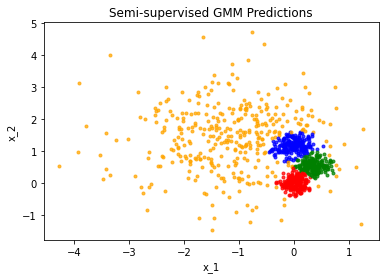

Running semi-supervised EM algorithm...
Iter 1, Likelihood -3266.26110514448
Iter 2, Likelihood -3071.6603455224367
Iter 3, Likelihood -2883.606749492993
Iter 4, Likelihood -2725.77255006417
Iter 5, Likelihood -2582.216218839015
Iter 6, Likelihood -2456.9380684253797
Iter 7, Likelihood -2388.6782692450142
Iter 8, Likelihood -2351.3067592290136
Iter 9, Likelihood -2333.3224652950726
Iter 10, Likelihood -2328.712342471495
Iter 11, Likelihood -2327.5050407490244
Iter 12, Likelihood -2327.0024798041027
Iter 13, Likelihood -2326.7515901075017
Iter 14, Likelihood -2326.6207748185952
Iter 15, Likelihood -2326.5518995956927
Iter 16, Likelihood -2326.5158782882345
Iter 17, Likelihood -2326.4974613089244
Iter 18, Likelihood -2326.488454747965
Iter 19, Likelihood -2326.4844083534385
Iter 20, Likelihood -2326.48290539232
Iter 21, Likelihood -2326.482645456734


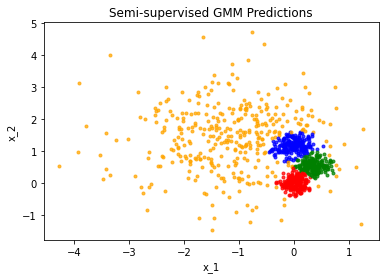

Running semi-supervised EM algorithm...
Iter 1, Likelihood -3265.4660943436443
Iter 2, Likelihood -3068.4138043227863
Iter 3, Likelihood -2875.7655878974538
Iter 4, Likelihood -2711.870590363249
Iter 5, Likelihood -2576.2729674504717
Iter 6, Likelihood -2456.3478410841944
Iter 7, Likelihood -2390.863398181822
Iter 8, Likelihood -2353.748106801969
Iter 9, Likelihood -2334.3175591101676
Iter 10, Likelihood -2329.0533570766693
Iter 11, Likelihood -2327.6983450611315
Iter 12, Likelihood -2327.122433398214
Iter 13, Likelihood -2326.8234371211174
Iter 14, Likelihood -2326.662158118621
Iter 15, Likelihood -2326.5748764395194
Iter 16, Likelihood -2326.528132111592
Iter 17, Likelihood -2326.5036606181748
Iter 18, Likelihood -2326.4913409678948
Iter 19, Likelihood -2326.4855472217732
Iter 20, Likelihood -2326.483168341846
Iter 21, Likelihood -2326.4825041937943


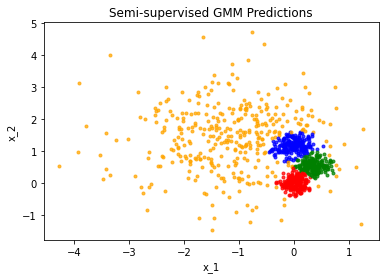

In [7]:
np.random.seed(42)
for t in range(NUM_TRIALS):
    #main(is_semi_supervised=False, trial_num=t)
    main(is_semi_supervised=True, trial_num=t)